# Flan-t5-Small - Test Classification Prompts

In this notebook we are going to use the **Amazon Review Dataset** to test Promptmeteo in the sentiment analysis task

## 1. Data Preparation - EN - Build sentiment dataset.

The dataset contains reviews from Amazon in English collected between November 1, 2015 and November 1, 2019. Each record in the dataset contains the review text, the review title, the star rating, an anonymized reviewer ID, an anonymized product ID and the coarse-grained product category (e.g. ‘books’, ‘appliances’, etc.). The corpus is balanced across stars, so each star rating constitutes 20% of the reviews in each language.

In [1]:
import polars as pl
import sys; sys.path.append('..')

data = pl.read_parquet('../data/amazon_reviews_en/amazon_reviews_multi-test.parquet')
sql = pl.SQLContext()
sql.register('data', data)

sentiment_data = sql.execute("""
    SELECT
        review_body as REVIEW,
        CASE
            WHEN stars=1 THEN 'negative'
            WHEN stars=3 THEN 'neutral'
            WHEN stars=5 THEN 'positive'
            ELSE null
        END AS TARGET,
    FROM data
    WHERE stars!=2 AND stars!=4;
    """).collect().sample(fraction=1.0, shuffle=True, seed=0)

train_reviews = sentiment_data.head(500).select('REVIEW').to_series().to_list()
train_targets = sentiment_data.head(500).select('TARGET').to_series().to_list()

test_reviews = sentiment_data.tail(200).select('REVIEW').to_series().to_list()
test_targets = sentiment_data.tail(200).select('TARGET').to_series().to_list()

sentiment_data.head()

REVIEW,TARGET
str,str
"""I reuse my Nes…","""positive"""
"""Fits great kin…","""positive"""
"""Movie freezes …","""negative"""
"""This is my thi…","""positive"""
"""For the money,…","""neutral"""


&nbsp;


&nbsp;


&nbsp;


## 2. EN - Sin entrenamiento

### Prueba 1

In [2]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Please provide a step-by-step argument for your answer, explain why you
    believe your final choice is justified, and make sure to conclude your
    explanation with the name of the class you have selected as the correct
    one, in lowercase and without punctuation."


ANSWER_FORMAT:
    "In your response, include only the name of the class as a single word, in
    lowercase, without punctuation, and without adding any other statements or
    words."
'''

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)



PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Please provide a step-by-step argument for your answer, explain why you believe your final choice is justified, and make sure to conclude your explanation with the name of the class you have selected as the correct one, in lowercase and without punctuation. In your response, include only the name of the class as a single word, in lowercase, without punctuation, and without adding any other statements or words.

Input text: It keeps the litter box smelling nice. 


MODEL OUTPUT

 neutral


PARSE RESULT

 ['neutral']


PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', '

<Axes: >

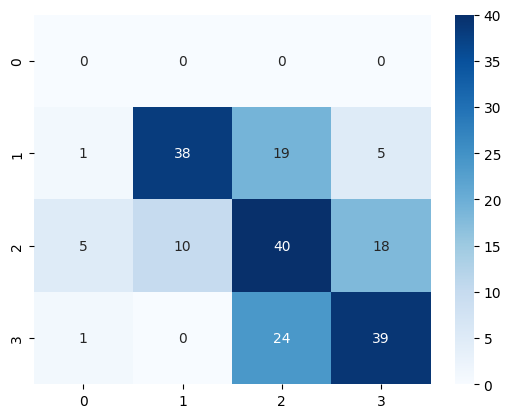

In [5]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [6]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Think step by step you answer."


ANSWER_FORMAT:
    "In your response, include only the name of the class predicted."
'''

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Think step by step you answer. In your response, include only the name of the class predicted.

Input text: It keeps the litter box smelling nice. 


MODEL OUTPUT

 neutral


PARSE RESULT

 ['neutral']


PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Think step by step you answer. In your response, include only the name of the class predicted.

Input text: Installed this on our boat and am very happy with the results. Great product! 


MODEL OUTPUT

 positive


PARSE RESULT

 ['positive']


PROMPT INPUT

  I need you to help me with a text c

<Axes: >

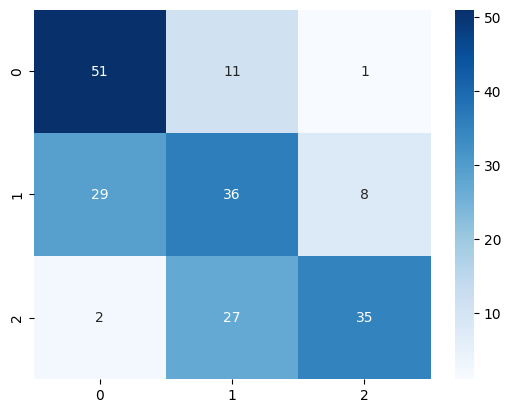

In [8]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 3

In [15]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    ""


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    ""


ANSWER_FORMAT:
    ""
'''

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  I need you to help me with a text classification task.  I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
 

Input text: It keeps the litter box smelling nice. 


MODEL OUTPUT

 neutral


PARSE RESULT

 ['neutral']


PROMPT INPUT

  I need you to help me with a text classification task.  I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
 

Input text: Installed this on our boat and am very happy with the results. Great product! 


MODEL OUTPUT

 positive


PARSE RESULT

 ['positive']


PROMPT INPUT

  I need you to help me with a text classification task.  I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
 

Input text: It is really nice to have my favorite sugar alternative packaged in little take along packets! I LOVE swerve, and it is so convenient to have these to throw in my purse for dining 

<Axes: >

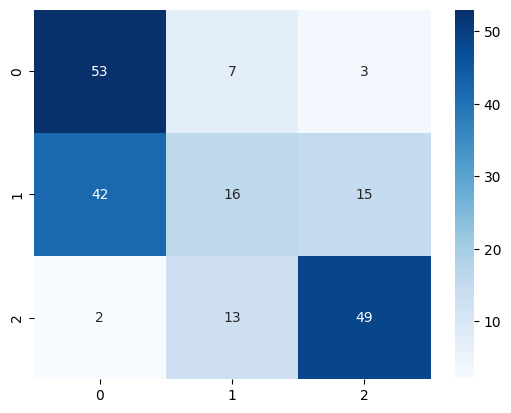

In [17]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

## 3. EN - Con entrenamiento

### Prueba 1

In [24]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Please provide a step-by-step argument for your answer, explain why you
    believe your final choice is justified, and make sure to conclude your
    explanation with the name of the class you have selected as the correct
    one, in lowercase and without punctuation."


ANSWER_FORMAT:
    "In your response, include only the name of the class as a single word, in
    lowercase, without punctuation, and without adding any other statements or
    words."
'''

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 5,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets
)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Please provide a step-by-step argument for your answer, explain why you believe your final choice is justified, and make sure to conclude your explanation with the name of the class you have selected as the correct one, in lowercase and without punctuation. In your response, include only the name of the class as a single word, in lowercase, without punctuation, and without adding any other statements or words.

INPUT: Very strong cheap pleather smell that took a few days to air out. One of the straps clips onto the zipper, so be careful of the zipper slowly coming undone as you walk.
OUTPUT: neutral

INPUT: The 8 year old nephew said he wanted this for his birthday. I felt it was a bit much for a toy but he caught me on a good day. Come to

Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Please provide a step-by-step argument for your answer, explain why you believe your final choice is justified, and make sure to conclude your explanation with the name of the class you have selected as the correct one, in lowercase and without punctuation. In your response, include only the name of the class as a single word, in lowercase, without punctuation, and without adding any other statements or words.

INPUT: I was very disappointed in this item. It is very soft and not chewy. It falls apart in your hand. My dog eats them but I prefer a more chewy treat for my dog.
OUTPUT: negative

INPUT: Just can't get use to the lack of taste with this ceylon cinnamon. I have to use so much to get any taste at all. This is the first ceylon I've

<Axes: >

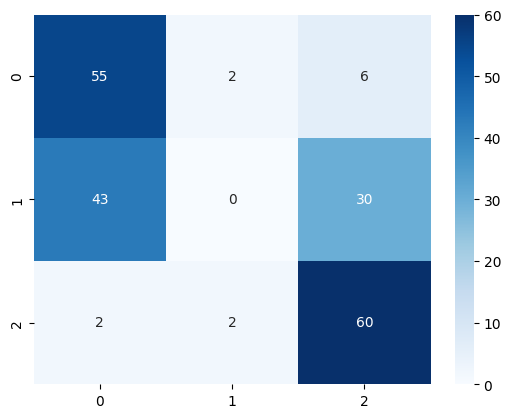

In [26]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [27]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Think step by step you answer."


ANSWER_FORMAT:
    "In your response, include only the name of the class predicted."
'''

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 5,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)



PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Think step by step you answer. In your response, include only the name of the class predicted.

INPUT: Very strong cheap pleather smell that took a few days to air out. One of the straps clips onto the zipper, so be careful of the zipper slowly coming undone as you walk.
OUTPUT: neutral

INPUT: The 8 year old nephew said he wanted this for his birthday. I felt it was a bit much for a toy but he caught me on a good day. Come to find out it's a fragile collectible so the nephew lost all the small parts the moment he opened it. I guess it's adequate for collectors that want detail on such a small figurine.
OUTPUT: neutral

INPUT: It leaves white residue all over dishes! Gross!
OUTPUT: negative

INPUT: Really can't say because cat refused to t

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  I need you to help me with a text classification task. The texts you will be processing are from the product reviews domain. I want you to classify the texts into one of the following categories: ['positive', 'negative', 'neutral'].
Think step by step you answer. In your response, include only the name of the class predicted.

INPUT: I was very disappointed in this item. It is very soft and not chewy. It falls apart in your hand. My dog eats them but I prefer a more chewy treat for my dog.
OUTPUT: negative

INPUT: Just can't get use to the lack of taste with this ceylon cinnamon. I have to use so much to get any taste at all. This is the first ceylon I've tried so I can't compare. Just not impressed. I agree with some others that it taste more like red hot candy smells. Hope I can find some that has some flavor. I really don't want to go back to the other cinnamon that is bad for us.
OUTPUT: neutral

INPUT: I like everything about the pill box except its size. I take 

<Axes: >

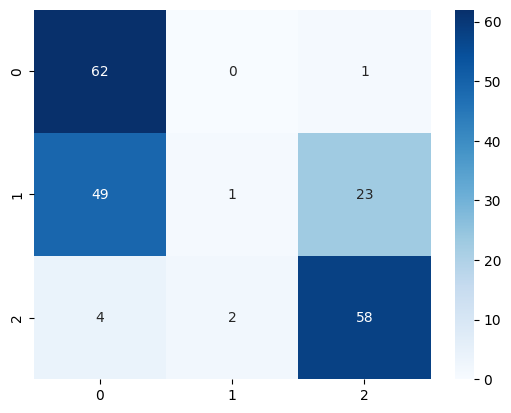

In [30]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

&nbsp;


### Prueba 3

In [31]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"

PROMPT_DOMAIN:
    ""

PROMPT_LABELS:
    ""

PROMPT_DETAIL:
    ""

CHAIN_THOUGHT:
    ""

ANSWER_FORMAT:
    ""
'''

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  I need you to help me with a text classification task.  
 

INPUT: Very strong cheap pleather smell that took a few days to air out. One of the straps clips onto the zipper, so be careful of the zipper slowly coming undone as you walk.
OUTPUT: neutral

INPUT: The 8 year old nephew said he wanted this for his birthday. I felt it was a bit much for a toy but he caught me on a good day. Come to find out it's a fragile collectible so the nephew lost all the small parts the moment he opened it. I guess it's adequate for collectors that want detail on such a small figurine.
OUTPUT: neutral

INPUT: It leaves white residue all over dishes! Gross!
OUTPUT: negative

INPUT: Really can't say because cat refused to try it. I gave it to someone else to try
OUTPUT: negative

INPUT: Wouldn’t keep air the first day of use!!!
OUTPUT: negative

INPUT: Way to sensitive turns on and off 1000 times a night I guess it picks up bugs or something
OUTPUT: negative

INPUT: Smudges easily and co

<Axes: >

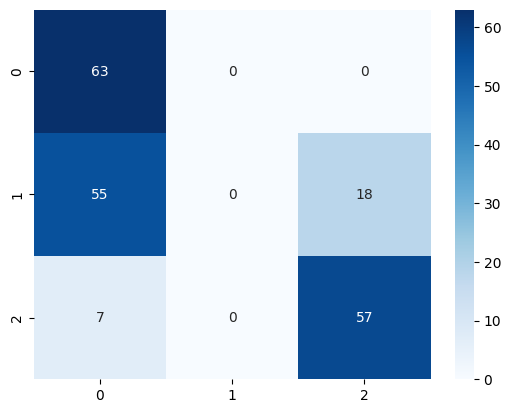

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 10,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

<Axes: >

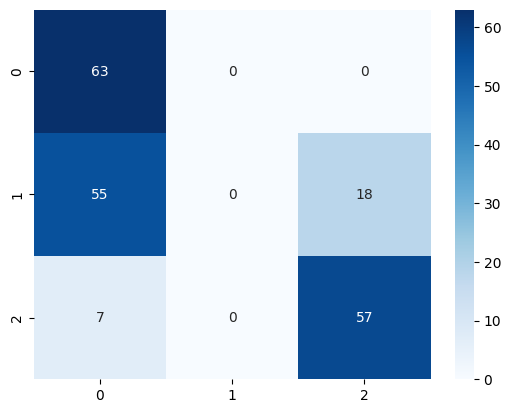

In [33]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

&nbsp;


&nbsp;


## 4. Data Preparation - SP - Build sentiment dataset.

In [60]:
import polars as pl

data = pl.read_parquet('../data/amazon_reviews_sp/amazon_reviews_multi-test.parquet')
data.head()

sql = pl.SQLContext()
sql.register('data', data)

sentiment_data = sql.execute("""
    SELECT
        review_body as REVIEW,
        CASE
            WHEN stars=1 THEN 'negativo'
            WHEN stars=3 THEN 'neutro'
            WHEN stars=5 THEN 'positivo'
            ELSE null
        END AS TARGET,
    FROM data
    WHERE stars!=2 AND stars!=4;
    """).collect().sample(fraction=1.0, shuffle=True, seed=0)

train_reviews = sentiment_data.head(500).select('REVIEW').to_series().to_list()
train_targets = sentiment_data.head(500).select('TARGET').to_series().to_list()

test_reviews = sentiment_data.tail(200).select('REVIEW').to_series().to_list()
test_targets = sentiment_data.tail(200).select('TARGET').to_series().to_list()

sentiment_data.head()

REVIEW,TARGET
str,str
"""El filtro de d…","""positivo"""
"""Un poquito esc…","""positivo"""
"""Para qué decir…","""negativo"""
"""Mi hija esta e…","""positivo"""
"""Se podría mejo…","""neutro"""


&nbsp;


&nbsp;


&nbsp;


## 5 SP - Sin Entrenamiento

### Prueba 1

In [61]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Por favor argumenta tu respuesta paso a paso, explica por qué crees que
    está justificada tu elección final, y asegúrate de que acabas tu
    explicación con el nombre de la clase que has escogido como la
    correcta, en minúscula y sin puntuación."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    palabra, en minúscula, sin puntuación, y sin añadir ninguna otra
    afirmación o palabra."
'''

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Por favor argumenta tu respuesta paso a paso, explica por qué crees que está justificada tu elección final, y asegúrate de que acabas tu explicación con el nombre de la clase que has escogido como la correcta, en minúscula y sin puntuación. En tu respuesta incluye sólo el nombre de la clase, como una única palabra, en minúscula, sin puntuación, y sin añadir ninguna otra afirmación o palabra.

Texto de entrada: Fue un regalo para mi madre que usa la moto a diario y esta encantada con ellas, además de ser bastante resistentes, tienen más de un año y están muy bien. 


MODEL OUTPUT

 I was a gift for my mother who used the bike to ride and this encantada with them, more than once, has a year and is very well.


PARSE RESULT

 ['']


PROMPT

Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Por favor argumenta tu respuesta paso a paso, explica por qué crees que está justificada tu elección final, y asegúrate de que acabas tu explicación con el nombre de la clase que has escogido como la correcta, en minúscula y sin puntuación. En tu respuesta incluye sólo el nombre de la clase, como una única palabra, en minúscula, sin puntuación, y sin añadir ninguna otra afirmación o palabra.

Texto de entrada: A alguien le ha llegado? A mí me mandaron un mensaje k me llega el lunes pero.....he visto k desde k lo pedí han modificado la descripción y creo k si llega no será el britax b emotion 4 k llevo pidiendo desde hace meses. 


MODEL OUTPUT

 Por qué tuvieron a alguien le ha llegado? A m me mandaron un mensaje k me llega el lunes per

<Axes: >

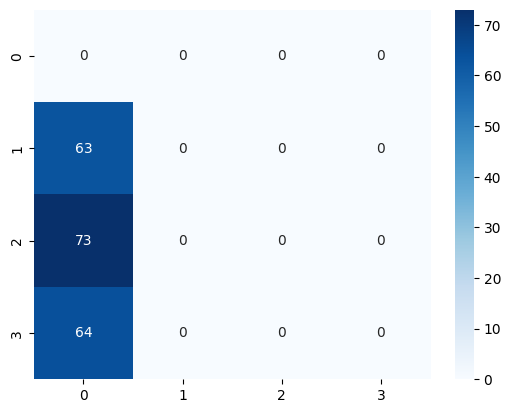

In [63]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [64]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Argumenta tu respuesta paso a paso."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    respuesta"
'''

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Argumenta tu respuesta paso a paso. En tu respuesta incluye sólo el nombre de la clase, como una única respuesta

Texto de entrada: Fue un regalo para mi madre que usa la moto a diario y esta encantada con ellas, además de ser bastante resistentes, tienen más de un año y están muy bien. 


MODEL OUTPUT

 I was a gift for my mother who used the bike to ride and this encantada with them, more than once, has a year and is very well.


PARSE RESULT

 ['']


PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Argumenta tu respuesta paso a paso. 

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Argumenta tu respuesta paso a paso. En tu respuesta incluye sólo el nombre de la clase, como una única respuesta

Texto de entrada: A alguien le ha llegado? A mí me mandaron un mensaje k me llega el lunes pero.....he visto k desde k lo pedí han modificado la descripción y creo k si llega no será el britax b emotion 4 k llevo pidiendo desde hace meses. 


MODEL OUTPUT

 No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No Answer> No


PARSE RESULT

 ['']


PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías:

<Axes: >

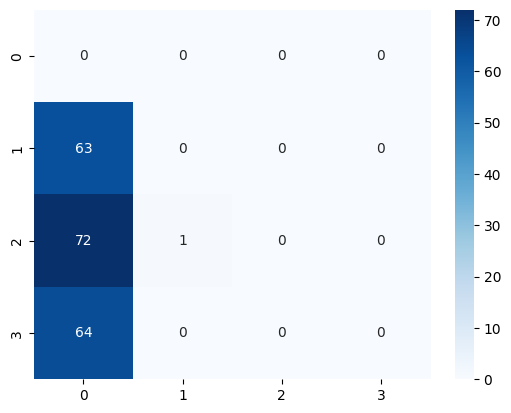

In [66]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 3

In [67]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    ""


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    ""


ANSWER_FORMAT:
    ""
'''

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 0,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto.  Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
 

Input text: Fue un regalo para mi madre que usa la moto a diario y esta encantada con ellas, además de ser bastante resistentes, tienen más de un año y están muy bien. 


MODEL OUTPUT

 He was a gift for my mother who used the bike to ride and this encantada with them, more than being very resistant, has a lot of a year and is very well.


PARSE RESULT

 ['']


PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto.  Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
 

Input text: Son dos pantallas protectoras bastante fáciles de instalar. Vienen en una cajita muy elegante con un montón de complementos e instrucciones sencillas para que puedas instalarlas con suma facilidad. No se ensucian mucho y aguantan bastante. 



Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto.  Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
 

Input text: A alguien le ha llegado? A mí me mandaron un mensaje k me llega el lunes pero.....he visto k desde k lo pedí han modificado la descripción y creo k si llega no será el britax b emotion 4 k llevo pidiendo desde hace meses. 


MODEL OUTPUT

 A alguien le ha llegado? A m me mandaron un mensaje k me llega el lunes pero.....he visto k desde k lo ped han modificado


PARSE RESULT

 ['']


PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto.  Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
 

Input text: No sé quién puede estar interesado en semejante producto. Casi ninguna de las funciones funcionan. Lo que funciona es la calculadora,el reproductor de música, lo de contar los pasos y poco más. No sirve para 

<Axes: >

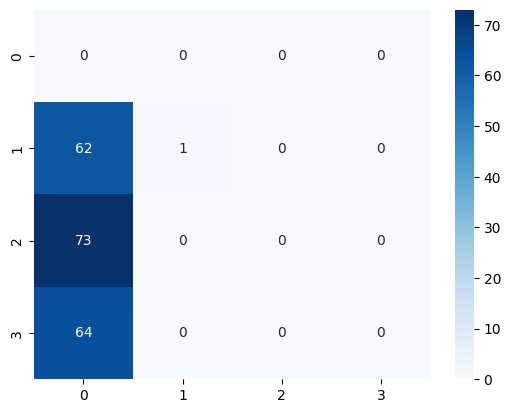

In [69]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

## ES - Con entrenamiento

### Prueba 1

In [70]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Por favor argumenta tu respuesta paso a paso, explica por qué crees que
    está justificada tu elección final, y asegúrate de que acabas tu
    explicación con el nombre de la clase que has escogido como la
    correcta, en minúscula y sin puntuación."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    palabra, en minúscula, sin puntuación, y sin añadir ninguna otra
    afirmación o palabra."
'''

In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 5,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

Token indices sequence length is longer than the specified maximum sequence length for this model (852 > 512). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Por favor argumenta tu respuesta paso a paso, explica por qué crees que está justificada tu elección final, y asegúrate de que acabas tu explicación con el nombre de la clase que has escogido como la correcta, en minúscula y sin puntuación. En tu respuesta incluye sólo el nombre de la clase, como una única palabra, en minúscula, sin puntuación, y sin añadir ninguna otra afirmación o palabra.

EJEMPLO: Era un regalo y la verdad que esta dando la talla que deseaba!! Facil de utilización y muy creativo.
RESPUESTA: positivo

EJEMPLO: A los 3-4 dias dd haber llegado el telefono, la camara trasera dejo de funcionar. Me puse en contacto con ellos para tramitar un cambio, pero me pedian que devolviera este primero y luego ellos me mandaban otro

<Axes: >

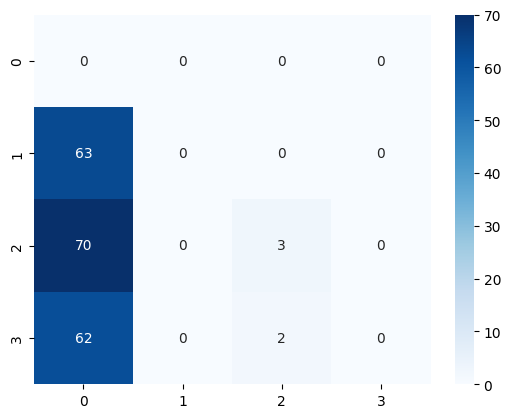

In [72]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [73]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Argumenta tu respuesta paso a paso."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    respuesta"
'''

In [74]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 5,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto. Los textos que vas procesar del ambito de opiniones de productos. Quiero que me clasifiques los textos una de las siguientes categorías: ['positivo', 'negativo', 'neutro'].
Argumenta tu respuesta paso a paso. En tu respuesta incluye sólo el nombre de la clase, como una única respuesta

EJEMPLO: Era un regalo y la verdad que esta dando la talla que deseaba!! Facil de utilización y muy creativo.
RESPUESTA: positivo

EJEMPLO: A los 3-4 dias dd haber llegado el telefono, la camara trasera dejo de funcionar. Me puse en contacto con ellos para tramitar un cambio, pero me pedian que devolviera este primero y luego ellos me mandaban otro, por lo que me quedaba sin movil, creo que lo mas conveniente es igual que viene el mensajero a traerme uno nuevo, a ma vez que se lleve el estropeado... no me podia quedar sin movil ya que solo tengo este y lo necesito. A dia de hoy todavía ando con el movil sin camara trasera...

<Axes: >

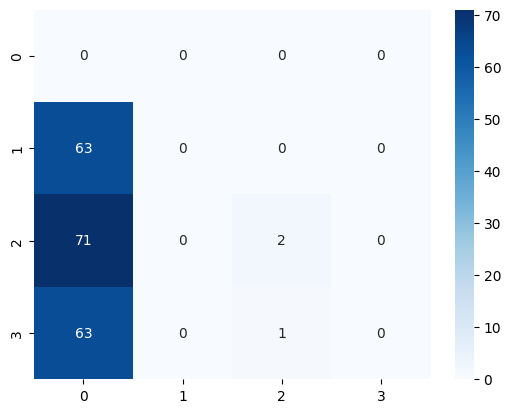

In [75]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 3

In [76]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    ""


PROMPT_LABELS:
    ""


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    ""


ANSWER_FORMAT:
    ""
'''

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'google/flan-t5-small',
    model_provider_name  = 'hf_pipeline',
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positivo','negativo','neutro'],
    selector_k           = 10,
    verbose              = True
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(




PROMPT INPUT

  Necesito que me ayudes en una tarea de clasificación de texto.  
 

EJEMPLO: Era un regalo y la verdad que esta dando la talla que deseaba!! Facil de utilización y muy creativo.
RESPUESTA: positivo

EJEMPLO: A los 3-4 dias dd haber llegado el telefono, la camara trasera dejo de funcionar. Me puse en contacto con ellos para tramitar un cambio, pero me pedian que devolviera este primero y luego ellos me mandaban otro, por lo que me quedaba sin movil, creo que lo mas conveniente es igual que viene el mensajero a traerme uno nuevo, a ma vez que se lleve el estropeado... no me podia quedar sin movil ya que solo tengo este y lo necesito. A dia de hoy todavía ando con el movil sin camara trasera... un desastre. NO LO RECOMIENDO PARA NADA!
RESPUESTA: negativo

EJEMPLO: Está bien para el precio que tiene, no sirve para llevar cosas frías, el tamaño es un poco justo, caben dos tuppers pequeños y una lata
RESPUESTA: neutro

EJEMPLO: Tuve uno de la marca Kong y lo rompió en dos d

<Axes: >

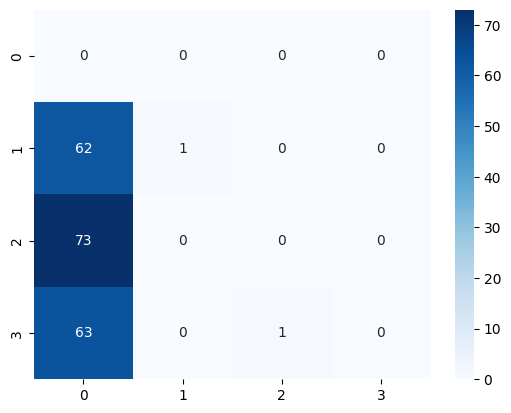

In [78]:
sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

## Conclusiones

* Parece que con el modelo Flan-t5-small, el mejor resultado se obtiene añadiendo más ejemplot y quitando la instrucción del prompt

* Parece que muchas veces los textos inyectados hacen que supere el tamaño del prompt. Sería bueno añadir algo que te permitiese controlar el número de textos máximos según el tamaño del prompt que admite el modelo seleccionado